This is a notebook with an example of the simulations carried out in https://arxiv.org/abs/2312.17146. We will use the Hydrogen molecule for this example.

In [35]:
#import libraries
import cirq
import tequila as tq
import numpy as np
import pickle
from matplotlib import pyplot as plt
import k_commute

In [36]:
#initialize a list of bond-lengths we will consider here
equilibrium_bl = 0.741
bond_lengths = [0.601, 0.741, 0.881]
bond_lengths.extend([i*0.5 for i in range(1,9)])
bond_lengths.sort()

print("We are considering the following configurations:", bond_lengths)

We are considering the following configurations: [0.5, 0.601, 0.741, 0.881, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]


In [37]:
#get Hamiltonian and commuting groups for a molecular configuration. The diagonalizing circuits are now generated using k-commutativity

Hamiltonians = []
Graph_circuits = [] # Previously retrieved from .pickle containing tq circuits

for bond in bond_lengths:
    file = open("../Hamiltonians/H2/H2_Hamiltonian_for_bond_length_{0}.pickle".format(bond),'rb')
    mol_Ham = pickle.load(file)
    file.close()
              
    Hamiltonians.append(mol_Ham)

    file = open("../groups_and_circuits/H2/H2_groups_and_circuits_for_bond_length_{0}.pickle".format(bond),'rb')
    groups, circuits = pickle.load(file)
    file.close()
    
    Graph_circuits.append(circuits)

groups_and_circuits = []
k_circuits = []
for hamiltonian in Hamiltonians:
    groups, circuits = k_commute.diag_circ_from_ham(mol_Ham.to_openfermion(), 4)
    tqcircuits = []
    
    #tqcircuits = tq.import_open_qasm(circuit.to_qasm) for circuit in circuits

    #for circuit in circuits:
    #    print(circuit)
    #    a = circuit.to_qasm()
    #    print(tq.import_open_qasm(a))
        

    groups_and_circuits.append(zip(groups,circuits))
    k_circuits.append(circuits)

Hams_groups_circs = zip(Hamiltonians,groups_and_circuits)


In [38]:
qasm_circuit = circuits[0].to_qasm()
tq_circuit = tq.import_open_qasm(qasm_circuit)
#tq_circuit

In [39]:
all_tq_diags = []
for circ_list in k_circuits:
    
    tq_circuits = []
    for circuit in circ_list:
        #print(circuit)
        qasm_circuit = circuit.to_qasm()
        tq_circuits.append(tq.import_open_qasm(qasm_circuit))
        #tq.draw(tq.import_open_qasm(qasm_circuit))
    all_tq_diags.append(tq_circuits)

In [40]:
cqc1 = circuit
tqc1 = tq.import_open_qasm(qasm_circuit)

In [41]:
#let's calculate the ground state energies of the molecule at the different configurations
FCI_eners = []

for Ham in Hamiltonians:
    v,vv = np.linalg.eigh(Ham.to_matrix())
    FCI_eners.append(v[0])
    
print("The exact ground state energies of the molecules are:", FCI_eners)

The exact ground state energies of the molecules are: [-1.0551597946880173, -1.1166462657704586, -1.1372744055258712, -1.1237206708647083, -1.1011503301329568, -0.9981493533579184, -0.9486411121296494, -0.9360549199436622, -0.9336318445559841, -0.9332284055492808, -0.9331713618435846]


In [42]:
#Calculating HF energies
num_qubits = 4

HF_ener = []
for Ham in Hamiltonians:
    #simulating reference state-prep circuit (in BK basis)
    ref = tq.QCircuit()    
    ref += tq.gates.X(0)
    
    Exp = tq.ExpectationValue(U=ref, H= Ham)
    energy = tq.simulate(Exp, backend="qulacs")
    #print(energy)
    HF_ener.append(energy)
    
    
print("Hartree-Fock energy:", HF_ener)

Hartree-Fock energy: [-1.0429962747511712, -1.1014552070447619, -1.1167061372172085, -1.0961661385920694, -1.0661086491853156, -0.9108735543822686, -0.7837926540830397, -0.7029435995786047, -0.6560482510473122, -0.6298201100573617, -0.6148699739991873]


In [43]:
g_seed = 1

def random_number(num_param):
    """
    This function calls the numpy.random.randn function with
    a new seed every time, and returns the values
    """
    global g_seed
    rand_state = np.random.RandomState(seed = g_seed)
    g_seed += int(np.abs(np.random.randn(1)[0]*10) + 1)
    return rand_state.randn(num_param)

In [44]:
#Now we construct the H-GSA ansatz and carry optimization
mean_vqe_eners = []
std_vqe_eners = []

mean_vqe_errors = []
vqe_errors_min = []
vqe_errors_max = []

for index, (Ham, circuits) in enumerate(zip(Hamiltonians, Graph_circuits)):
    
    #construct the CCA
    HGSA = tq.QCircuit()
    
    #Add the reference state-prep circuit (in BK basis)
    HGSA += tq.gates.X(0)
    
    #only considering the non-empty circuits
    for i, cir in enumerate(circuits[1:]):
       
        #Add the Clifford circuit
        HGSA += cir.dagger()
        
        #Add the single qubit rotation layer
        for qubit in range(num_qubits):
            var_1 = tq.Variable("th_q{0}_l{1}".format(qubit, i))
            var_2 = tq.Variable("ph_q{0}_l{1}".format(qubit, i))
            var_3 = tq.Variable("la_q{0}_l{1}".format(qubit, i))
            
            HGSA += tq.gates.Rz(var_1, qubit)                
            HGSA += tq.gates.Ry(var_2, qubit)
            HGSA += tq.gates.Rz(var_3, qubit)                
            HGSA += tq.gates.Ry(-1*var_2, qubit)
            HGSA += tq.gates.Rz(-1*var_1, qubit)
        
        #Add the Clifford circuit inverse
        HGSA += cir
    
    energies = []
    errors = []
    num_samples = 5
    for samp in range(num_samples):
        initial_values = {}

        for var_ in HGSA.extract_variables():
            if "th" in str(var_) or "ph" in str(var_):
                initial_values[var_] = random_number(1)[0]
            else:
                initial_values[var_] = 1e-6
        
    
        Exp = tq.ExpectationValue(U=HGSA, H= Ham)
        result = tq.minimize(objective=Exp,initial_values = initial_values, tol= 1e-6, method="bfgs" ,backend="qulacs", silent="True")
        energy = result.energy
        #print(energy)
        energies.append(energy)
        errors.append(energy - FCI_eners[index])
    
    mean_vqe_eners.append(np.mean(energies))
    std_vqe_eners.append(np.std(energies))
    
    mean_vqe_errors.append(np.mean(errors))
    vqe_errors_min.append(np.min(errors))
    vqe_errors_max.append(np.max(errors))
        
    
print("Energy from VQE with HGSA:", mean_vqe_eners)

In [ ]:
#repeat of HGSA code, now with K-commutativity diagonalizing circuits instead
mean_vqe_eners2 = []
std_vqe_eners2 = []

mean_vqe_errors2 = []
vqe_errors_min2 = []
vqe_errors_max2 = []

for index, (Ham, circuits) in enumerate(zip(Hamiltonians, all_tq_diags)): 
    
    #construct the CCA
    KA = tq.QCircuit()
    
    #Add the reference state-prep circuit (in BK basis)
    KA += tq.gates.X(0)
    
    #only considering the non-empty circuits
    for i, cir in enumerate(circuits[:]):
       
        #Add the Clifford circuit
        KA += cir.dagger()
        
        #Add the single qubit rotation layer
        for qubit in range(num_qubits):
            var_1 = tq.Variable("th_q{0}_l{1}".format(qubit, i))
            #var_2 = tq.Variable("ph_q{0}_l{1}".format(qubit, i))
            #var_3 = tq.Variable("la_q{0}_l{1}".format(qubit, i))
            
            KA += tq.gates.Rz(var_1, qubit)                
            #KA += tq.gates.Ry(var_2, qubit)
            #KA += tq.gates.Rz(var_3, qubit)                
            #KA += tq.gates.Ry(-1*var_2, qubit)
            #KA += tq.gates.Rz(-1*var_1, qubit)
        
        #Add the Clifford circuit inverse
        KA += cir
    
    energies = []
    errors = []
    num_samples = 5
    for samp in range(num_samples):
        initial_values = {}

        for var_ in KA.extract_variables():
            if "th" in str(var_) or "ph" in str(var_):
                initial_values[var_] = random_number(1)[0]
            else:
                initial_values[var_] = 1e-6
        
    
        Exp = tq.ExpectationValue(U=KA, H= Ham)
        result = tq.minimize(objective=Exp,initial_values = initial_values, tol= 1e-6, method="bfgs" ,backend="qulacs", silent="True")
        energy = result.energy
        #print(energy)
        energies.append(energy)
        errors.append(energy - FCI_eners[index])
    
    mean_vqe_eners2.append(np.mean(energies))
    std_vqe_eners2.append(np.std(energies))
    
    mean_vqe_errors2.append(np.mean(errors))
    vqe_errors_min2.append(np.min(errors))
    vqe_errors_max2.append(np.max(errors))
        
    
print("Energy from VQE with K-Commutativity Ansatz:", mean_vqe_eners2)

Energy from VQE with K-Commutativity Ansatz: [-1.042996274751168, -1.1014552070447587, -1.116706137217205, -1.0961661385920658, -1.0661086491853122, -0.9108735543822657, -0.7837926540830374, -0.7029435995786025, -0.6560482510473102, -0.6298201100573599, -0.6148699739991853]


In [ ]:
tq.minimize?

Signature:
tq.minimize(
    objective,
    method: str = 'bfgs',
    variables: list = None,
    initial_values: Union[dict, numbers.Number, Callable] = 0.0,
    maxiter: int = None,
    *args,
    **kwargs,
)
Docstring:
Parameters
----------
method: str:
   The optimization method (e.g. bfgs, cobyla, nelder-mead, ...)
   see 'tq.optimizers.show_available_methods()' for an overview
objective: tq.Objective:
   The abstract tequila objective to be optimized
variables: list of names:
   The variables which shall be optimized given as list
   Can be passed as list of names or list of tq variables
initial_values: dict:
   Initial values for the optimization, passed as dictionary
   with the variable names as keys.
   Alternatively `zero`, `random` or a single number are accepted
maxiter:
   maximum number of iterations
kwargs:
   further keyword arguments for the actual minimization functions
   can also be called directly as tq.minimize_modulename
   e.g. tq.minimize_scipy
   See their doc

In [ ]:
tq.optimizers.show_available_optimizers()

available methods for optimizer modules found on your system:
method               | optimizer module
--------------------------
NELDER-MEAD          | scipy
COBYLA               | scipy
POWELL               | scipy
SLSQP                | scipy
L-BFGS-B             | scipy
BFGS                 | scipy
CG                   | scipy
TNC                  | scipy
TRUST-KRYLOV         | scipy
NEWTON-CG            | scipy
DOGLEG               | scipy
TRUST-NCG            | scipy
TRUST-EXACT          | scipy
TRUST-CONSTR         | scipy
adam                 | gd
adagrad              | gd
adamax               | gd
nadam                | gd
sgd                  | gd
momentum             | gd
nesterov             | gd
rmsprop              | gd
rmsprop-nesterov     | gd
spsa                 | gd
Supported optimizer modules:  ['scipy', 'gpyopt', 'gd']
Installed optimizer modules:  ['scipy', 'gd']


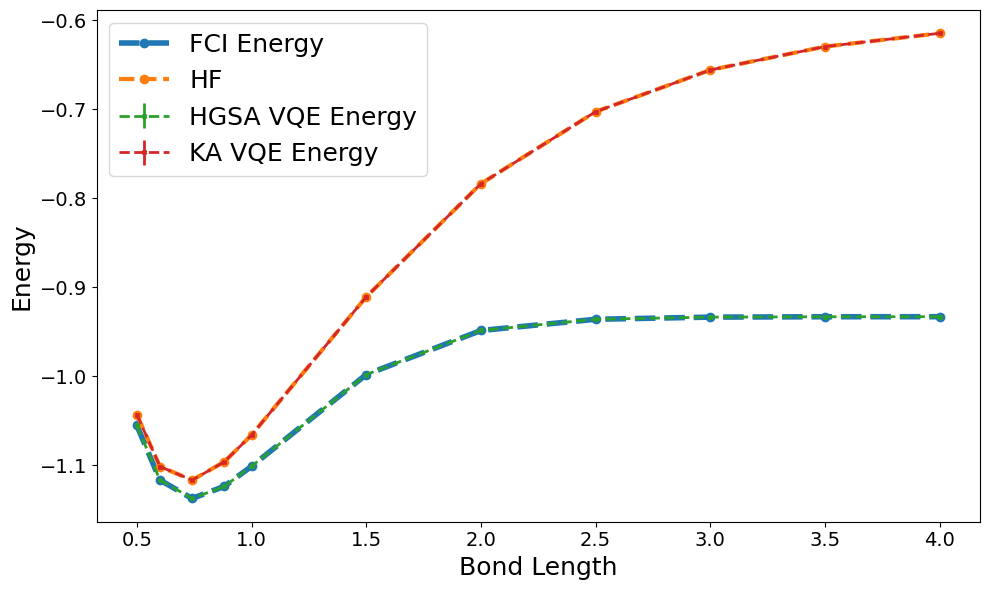

In [ ]:
plt.figure(figsize=(10,6))
plt.tight_layout()
plt.rc('legend',fontsize=18)
plt.plot(bond_lengths, FCI_eners, marker="o", markersize=6, linestyle="--", linewidth=4, label="FCI Energy")
plt.plot(bond_lengths, HF_ener, marker="o", markersize=6, linestyle="--", linewidth=3, label="HF")
plt.errorbar(bond_lengths, mean_vqe_eners, std_vqe_eners, marker="X", markersize=3, linestyle="--", linewidth=2, label="HGSA VQE Energy")
plt.errorbar(bond_lengths, mean_vqe_eners2, std_vqe_eners2, marker="X", markersize=3, linestyle="--", linewidth=2, label="KA VQE Energy")
plt.xlabel('Bond Length', fontsize=18)
plt.ylabel('Energy', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

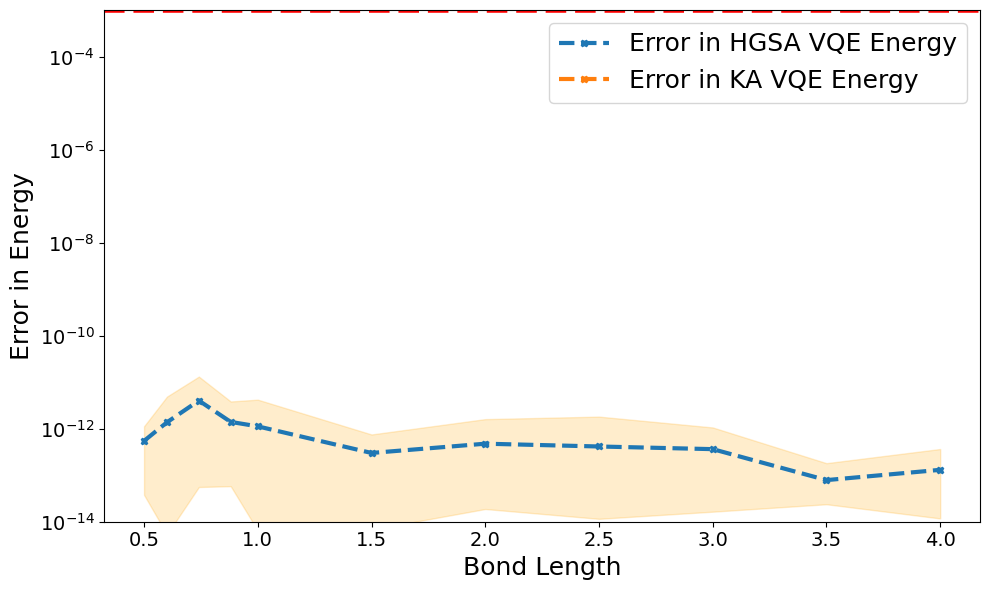

In [ ]:
plt.figure(figsize=(10,6))
plt.tight_layout()
plt.rc('legend',fontsize=18)
plt.ylim(1e-14, 1e-3)
plt.yscale("log")
plt.axhline(y=1e-3, color='r', linestyle='--',linewidth=4)
plt.plot(bond_lengths, mean_vqe_errors, marker="X", markersize=5, linestyle="--", linewidth=3, label="Error in HGSA VQE Energy")
plt.plot(bond_lengths, mean_vqe_errors2, marker="X", markersize=5, linestyle="--", linewidth=3, label="Error in KA VQE Energy")

plt.fill_between(bond_lengths, vqe_errors_min, vqe_errors_max, alpha=0.2, color ='orange')
plt.xlabel('Bond Length', fontsize=18)
plt.ylabel('Error in Energy', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()